In [1]:
import os
import torch
import numpy as np

import scanpy as sc
from anndata import AnnData

result_dir = "../edges/"
raw_type=False
use_edge=False

In [2]:
def read_data(sample,select=10,loss_threshold=10,normalize=False):
    results=torch.load(result_dir+"edges_"+sample+".pth")
    edges=results["edges"]
    if normalize:
        attention_score=torch.abs(torch.abs(results["attention_score"])/torch.sum(results["attention_score"],dim=-2,keepdim=True))
    else:
        attention_score=results["attention_score"]
        normalized_attention_score=torch.abs(torch.abs(results["attention_score"])/torch.sum(results["attention_score"],dim=-2,keepdim=True))
    print(attention_score.shape)
    position_x=results["position_x"]
    position_y=results["position_y"]
    cell_type_name=results["cell_type_name"]
    loss1=results["loss_all"].cpu()
    
    B,N=position_x.shape
    loss1=loss1.unsqueeze(dim=-1).repeat(1,select).reshape(-1).numpy()
    
    cell_type_target=[cell_type_name[i][0] for i in range(len(cell_type_name))]
    
    if normalize:
        indices=torch.topk(torch.sum(attention_score,dim=-1),k=select,dim=-1)[1]
        print(torch.topk(torch.mean(attention_score,dim=-1),k=select,dim=-1))
    else:
        tmp=torch.abs(torch.abs(results["attention_score"])/torch.sum(torch.abs(results["attention_score"]),dim=-2,keepdim=True))
        indices=torch.topk(torch.sum(tmp,dim=-1),k=select,dim=-1)[1]
        print(torch.topk(torch.mean(tmp,dim=-1),k=select,dim=-1))
    indices_tmp=torch.arange(0,indices.shape[0],1).unsqueeze(dim=-1).repeat(1,select)
    indices=torch.stack([indices_tmp.reshape(-1),indices.reshape(-1)],dim=0)

    if not use_edge:
        edges=attention_score
        print("not use edge",edges.shape)
    
    edges=edges[indices[0],indices[1],:].reshape(-1,edges.shape[-1]).numpy()
    attention_score=attention_score[indices[0],indices[1],:].reshape(-1,attention_score.shape[-1]).numpy()
    
    to_position_x=position_x[:,0:1].repeat(1,select).reshape(-1).numpy()
    to_position_y=position_y[:,0:1].repeat(1,select).reshape(-1).numpy()
    from_position_x=position_x[:,1:][indices[0],indices[1]].reshape(-1).numpy()
    from_position_y=position_y[:,1:][indices[0],indices[1]].reshape(-1).numpy()
    
    dx=position_x-position_x[:,0:1]
    dy=position_y-position_y[:,0:1]
    distances=torch.sqrt(torch.square(dx)+torch.square(dy))
    distances=distances[indices[0],indices[1]].reshape(-1).numpy()
    
    indices_np=indices.numpy()
    cell_types=np.array(cell_type_name)[:,1:][indices_np[0],indices_np[1]].reshape(B,select)
    print("number of cell types in this sample:",np.unique(np.array(cell_type_name)[:,0],return_counts=True))
    cell_types_pair=[]
    cell_types_target=[]
    flags=[]
    for i in range(cell_types.shape[0]):
        for j in range(cell_types.shape[1]):
            if not raw_type:
                cell_types_pair.append(cell_types[i][j]+"->"+cell_type_target[i])
                flags.append(cell_type_target[i]!=cell_types[i][j])
                cell_types_target.append(cell_type_target[i])
            else:
                cell_types_pair.append(cell_types[i][j].split(" ")[0]+"->"+cell_type_target[i].split(" ")[0])
                flags.append(cell_types[i][j].split(" ")[0]!=cell_type_target[i].split(" ")[0])
                cell_types_target.append(cell_type_target[i].split(" ")[0])

    print(edges.shape)
    adata = AnnData(edges)
    adata.obs['cell_type'] = cell_types_pair
    adata.obs['cell_type_target']=cell_types_target
    adata.obs['from_position_x'] = from_position_x
    adata.obs['from_position_y'] = from_position_y
    adata.obs['to_position_x'] = to_position_x
    adata.obs['to_position_y'] = to_position_y
    adata.obs['distance']=distances
    adata.obs['loss']=loss1
    # modify here
    adata.obsm["y"]=results["y"].repeat(1,select).reshape(results["y"].shape[0]*select,results["y"].shape[1]).numpy()
    adata.obsm["attention_score"]=attention_score
    
    adata=adata[adata.obs['loss']<loss_threshold,:]
    return adata
    
adata=read_data('H20.33.001.CX28.MTG.02.007.1.02.03',select=5)
print(adata)

torch.Size([15222, 49, 140])
torch.return_types.topk(
values=tensor([[0.0973, 0.0949, 0.0813, 0.0632, 0.0628],
        [0.1931, 0.1328, 0.0591, 0.0394, 0.0373],
        [0.1549, 0.1161, 0.1000, 0.0630, 0.0580],
        ...,
        [0.0854, 0.0802, 0.0634, 0.0546, 0.0465],
        [0.0823, 0.0593, 0.0405, 0.0387, 0.0384],
        [0.1395, 0.1028, 0.0976, 0.0938, 0.0678]]),
indices=tensor([[ 0, 30,  9, 15, 16],
        [ 0,  1, 20, 32, 46],
        [12, 15,  9,  1,  0],
        ...,
        [47, 40, 26, 35,  5],
        [16,  6, 25, 38,  0],
        [ 0, 24, 30, 23, 31]]))
not use edge torch.Size([15222, 49, 140])
number of cell types in this sample: (array(['Astrocyte', 'Chandelier', 'Endothelial', 'L2/3 IT', 'L4 IT',
       'L5 ET', 'L5 IT', 'L5/6 NP', 'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b',
       'Lamp5', 'Lamp5 Lhx6', 'Microglia-PVM', 'OPC', 'Oligodendrocyte',
       'Pax6', 'Pvalb', 'Sncg', 'Sst', 'Sst Chodl', 'VLMC', 'Vip'],
      dtype='<U15'), array([1523,   32,  799,  926, 1028

selecting edge types: ['L6 IT Car3->Oligodendrocyte' 'Microglia-PVM->Oligodendrocyte'
 'L6 IT Car3->Microglia-PVM' 'Oligodendrocyte->Microglia-PVM'
 'L5 IT->Microglia-PVM' 'L6 IT->L6 IT Car3' 'L5 IT->L4 IT'
 'Astrocyte->Microglia-PVM' 'L6 IT->Oligodendrocyte'
 'L6 IT->Microglia-PVM' 'Astrocyte->Oligodendrocyte'
 'L4 IT->Microglia-PVM' 'L2/3 IT->Microglia-PVM' 'L6b->Oligodendrocyte'
 'OPC->Oligodendrocyte' 'VLMC->Endothelial' 'L6 IT Car3->L6 IT'
 'L5 IT->Oligodendrocyte' 'Microglia-PVM->L2/3 IT' 'Endothelial->VLMC']


/tmp/ipykernel_1948960/1702885878.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/w

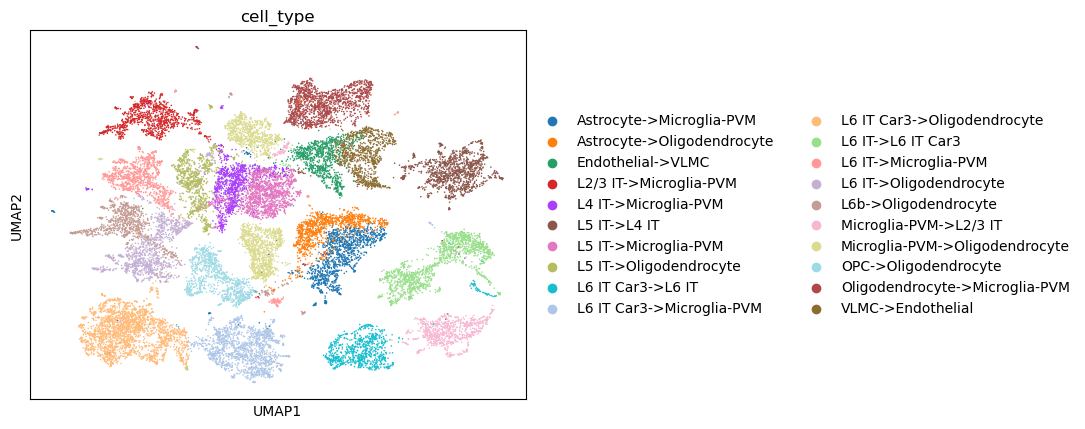

selecting edge types: ['L6 IT Car3->Oligodendrocyte' 'Microglia-PVM->Oligodendrocyte'
 'L6 IT Car3->Microglia-PVM' 'Oligodendrocyte->Microglia-PVM'
 'L5 IT->Microglia-PVM' 'L6 IT->L6 IT Car3' 'L5 IT->L4 IT'
 'Astrocyte->Microglia-PVM' 'L6 IT->Oligodendrocyte'
 'L6 IT->Microglia-PVM']


/tmp/ipykernel_1948960/1702885878.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/w

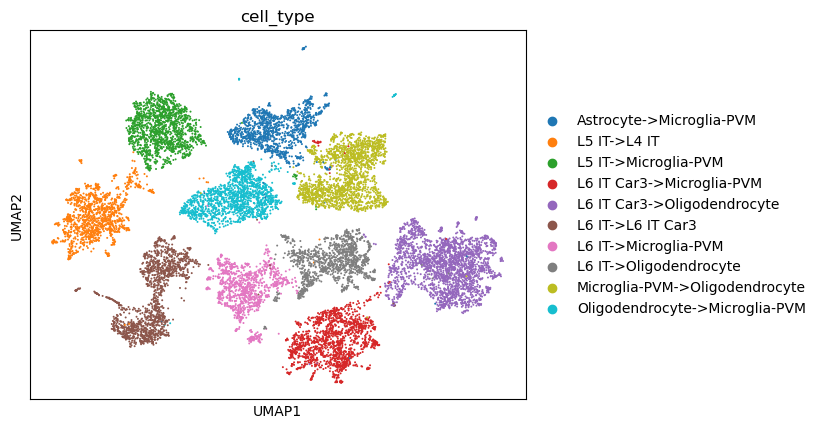

['L6 IT Car3->Oligodendrocyte' 'Microglia-PVM->Oligodendrocyte'
 'L6 IT Car3->Microglia-PVM' 'Oligodendrocyte->Microglia-PVM'
 'L5 IT->Microglia-PVM' 'L6 IT->L6 IT Car3' 'L5 IT->L4 IT'
 'Astrocyte->Microglia-PVM' 'L6 IT->Oligodendrocyte'
 'L6 IT->Microglia-PVM' 'Astrocyte->Oligodendrocyte'
 'L4 IT->Microglia-PVM' 'L2/3 IT->Microglia-PVM' 'L6b->Oligodendrocyte'
 'OPC->Oligodendrocyte' 'VLMC->Endothelial' 'L6 IT Car3->L6 IT'
 'L5 IT->Oligodendrocyte' 'Microglia-PVM->L2/3 IT' 'Endothelial->VLMC'
 'Microglia-PVM->Astrocyte' 'Endothelial->Astrocyte' 'L2/3 IT->L4 IT'
 'L6 IT->Astrocyte' 'L5 IT->L6 IT Car3' 'L2/3 IT->Astrocyte'
 'Microglia-PVM->Microglia-PVM' 'L4 IT->Oligodendrocyte'
 'L6 IT Car3->Astrocyte' 'Oligodendrocyte->OPC' 'L4 IT->L5 IT'
 'VLMC->Microglia-PVM' 'L6 IT->L5 IT' 'Oligodendrocyte->Oligodendrocyte'
 'L6b->L6 IT Car3' 'Microglia-PVM->Endothelial' 'L4 IT->L2/3 IT'
 'L5 IT->Astrocyte' 'Astrocyte->Endothelial' 'Astrocyte->VLMC'
 'L6 IT Car3->L6b' 'L5 IT->L6 IT' 'Microglia-PVM->

In [4]:
def plot(adata,color='cell_type',select_type_number=None,select_type=None):
    assert not ((select_type is None and select_type_number is None) and (select_type is not None and select_type_number is not None))
    
    if select_type_number is not None:
        unique=np.unique(adata.obs['cell_type'],return_counts=True)
        args = np.argsort(-unique[1])[:select_type_number]
        select_type = unique[0][args]
    print("selecting edge types:", select_type)
    
    flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
    adata_filtered=adata[flag,:]

    sc.pp.scale(adata_filtered)
    sc.tl.pca(adata_filtered)
    sc.pp.neighbors(adata_filtered)  # Compute the neighborhood graph
    sc.tl.umap(adata_filtered)  # Compute UMAP
    # Plot UMAP
    sc.pl.umap(adata_filtered, color=color)
    return adata_filtered

adata_20=plot(adata,select_type_number=20)
plot(adata,select_type_number=10)
unique=np.unique(adata.obs['cell_type'],return_counts=True)
print(unique[0][np.argsort(-unique[1])],unique[1][np.argsort(-unique[1])])

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


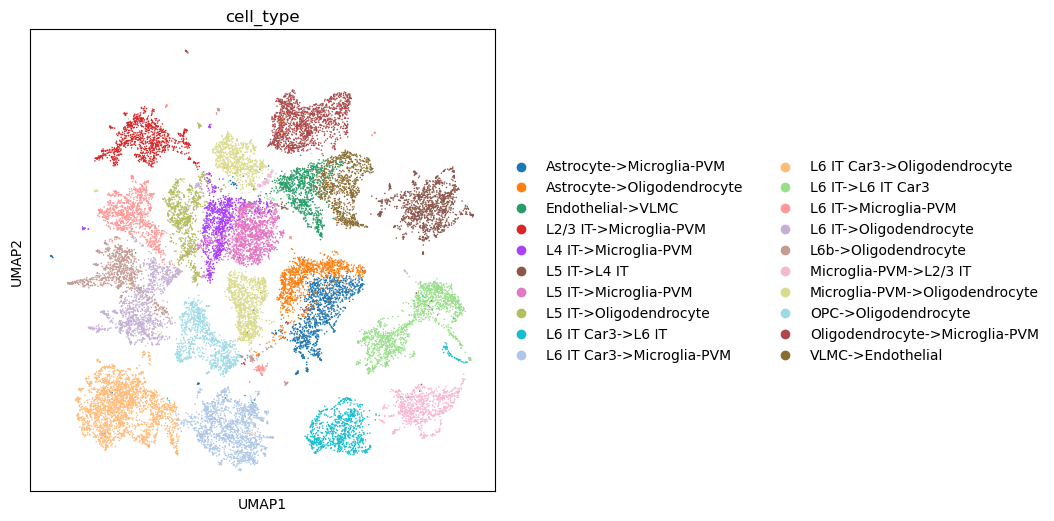

In [7]:
import matplotlib.pyplot as plt
with plt.rc_context({'figure.figsize': (6,6)}):
    sc.pl.umap(adata_20, color='cell_type')

torch.Size([7855, 99, 140])
torch.return_types.topk(
values=tensor([[0.5484, 0.0974, 0.0241, 0.0107, 0.0100],
        [0.1289, 0.0696, 0.0201, 0.0200, 0.0194],
        [0.1384, 0.0512, 0.0310, 0.0237, 0.0223],
        ...,
        [0.0526, 0.0324, 0.0288, 0.0285, 0.0244],
        [0.0544, 0.0539, 0.0489, 0.0382, 0.0322],
        [0.1011, 0.0441, 0.0396, 0.0216, 0.0206]]),
indices=tensor([[ 0,  1, 85,  6, 80],
        [ 0,  1, 19,  2, 13],
        [ 0,  1,  4,  2, 13],
        ...,
        [ 1, 80, 58,  0, 14],
        [34, 27, 58, 68, 69],
        [ 0,  1,  2,  5, 72]]))
not use edge torch.Size([7855, 99, 140])
number of cell types in this sample: (array(['Astrocyte', 'Chandelier', 'Endothelial', 'L2/3 IT', 'L4 IT',
       'L5 ET', 'L5 IT', 'L5/6 NP', 'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b',
       'Lamp5', 'Lamp5 Lhx6', 'Microglia-PVM', 'OPC', 'Oligodendrocyte',
       'Pax6', 'Pvalb', 'Sncg', 'Sst', 'Sst Chodl', 'VLMC', 'Vip'],
      dtype='<U15'), array([ 782,   17,  484,  563,  441, 

/tmp/ipykernel_2822987/426178560.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/wa

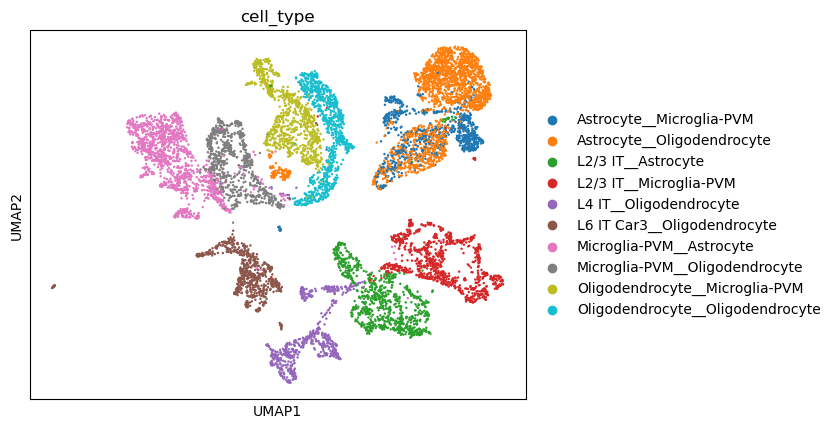

selecting edge types: ['Astrocyte__Oligodendrocyte' 'Microglia-PVM__Astrocyte'
 'L2/3 IT__Microglia-PVM' 'L2/3 IT__Astrocyte' 'Astrocyte__Microglia-PVM'
 'Oligodendrocyte__Oligodendrocyte' 'Oligodendrocyte__Microglia-PVM'
 'Microglia-PVM__Oligodendrocyte' 'L6 IT Car3__Oligodendrocyte'
 'L4 IT__Oligodendrocyte']


/tmp/ipykernel_2822987/426178560.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


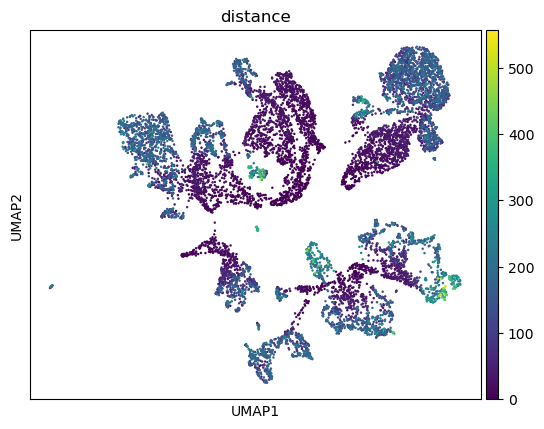

[['Astrocyte__Oligodendrocyte', 'Microglia-PVM__Astrocyte', 'L2/3 IT__Microglia-PVM', 'L2/3 IT__Astrocyte', 'Astrocyte__Microglia-PVM', 'Oligodendrocyte__Oligodendrocyte', 'Oligodendrocyte__Microglia-PVM', 'Microglia-PVM__Oligodendrocyte', 'L6 IT Car3__Oligodendrocyte', 'L4 IT__Oligodendrocyte', 'L4 IT__Microglia-PVM', 'L6 IT Car3__L6 IT Car3', 'L4 IT__L4 IT', 'Microglia-PVM__L2/3 IT', 'L4 IT__L5 IT', 'Pvalb__L2/3 IT', 'L2/3 IT__L4 IT', 'L6 CT__L6 IT', 'L6 IT Car3__Microglia-PVM', 'Endothelial__Microglia-PVM', 'VLMC__Endothelial', 'Astrocyte__Astrocyte', 'L5 IT__L6 IT Car3', 'Astrocyte__L2/3 IT', 'L6 IT Car3__Endothelial', 'L6 CT__L6 IT Car3', 'Oligodendrocyte__L6 IT Car3', 'Oligodendrocyte__OPC', 'Astrocyte__Endothelial', 'L6 IT Car3__L6b', 'Microglia-PVM__OPC', 'Microglia-PVM__Endothelial', 'L6 IT Car3__OPC', 'L5 IT__Microglia-PVM', 'VLMC__VLMC', 'VLMC__Microglia-PVM', 'L4 IT__Astrocyte', 'Endothelial__VLMC', 'Pvalb__Microglia-PVM', 'L5 IT__L6 IT', 'Astrocyte__VLMC', 'L4 IT__L6 IT Ca

/tmp/ipykernel_2822987/426178560.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/wa

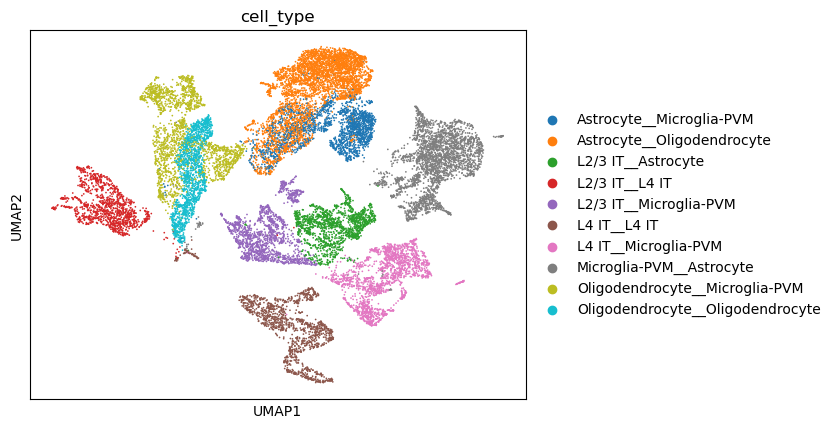

selecting edge types: ['Astrocyte__Oligodendrocyte' 'Microglia-PVM__Astrocyte'
 'Astrocyte__Microglia-PVM' 'Oligodendrocyte__Microglia-PVM'
 'L4 IT__Microglia-PVM' 'Oligodendrocyte__Oligodendrocyte'
 'L2/3 IT__Microglia-PVM' 'L2/3 IT__Astrocyte' 'L4 IT__L4 IT'
 'L2/3 IT__L4 IT']


/tmp/ipykernel_2822987/426178560.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


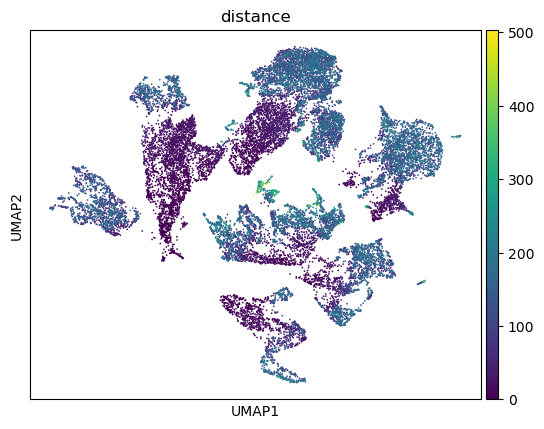

[['Astrocyte__Oligodendrocyte', 'Microglia-PVM__Astrocyte', 'Astrocyte__Microglia-PVM', 'Oligodendrocyte__Microglia-PVM', 'L4 IT__Microglia-PVM', 'Oligodendrocyte__Oligodendrocyte', 'L2/3 IT__Microglia-PVM', 'L2/3 IT__Astrocyte', 'L4 IT__L4 IT', 'L2/3 IT__L4 IT', 'L4 IT__Oligodendrocyte', 'L5 IT__L6 IT Car3', 'L6 IT Car3__Oligodendrocyte', 'Microglia-PVM__Oligodendrocyte', 'L4 IT__L5 IT', 'Endothelial__Microglia-PVM', 'L4 IT__Astrocyte', 'L6 IT Car3__L6 IT Car3', 'VLMC__Microglia-PVM', 'L6 CT__L6 IT', 'Microglia-PVM__L2/3 IT', 'VLMC__Endothelial', 'VLMC__VLMC', 'L4 IT__L2/3 IT', 'L2/3 IT__Oligodendrocyte', 'Oligodendrocyte__L6 IT Car3', 'L5 IT__L6 IT', 'L6 CT__L6 IT Car3', 'Astrocyte__L2/3 IT', 'Pvalb__L2/3 IT', 'Oligodendrocyte__L4 IT', 'Astrocyte__Astrocyte', 'L5 IT__Microglia-PVM', 'L6b__Oligodendrocyte', 'L6 IT__Oligodendrocyte', 'Microglia-PVM__Microglia-PVM', 'Oligodendrocyte__OPC', 'L6 IT__L6 IT Car3', 'L6 IT Car3__OPC', 'L6 IT Car3__L6 IT', 'Microglia-PVM__Endothelial', 'L6 IT 

/tmp/ipykernel_2822987/426178560.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/wa

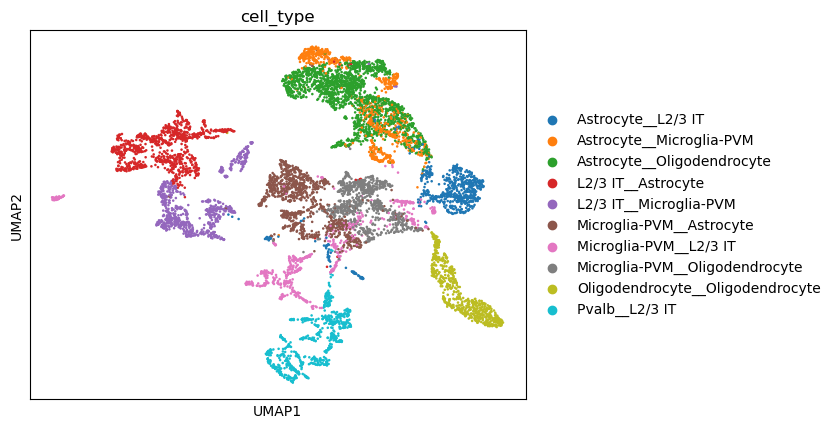

selecting edge types: ['Astrocyte__Oligodendrocyte' 'Microglia-PVM__Astrocyte'
 'L2/3 IT__Astrocyte' 'Microglia-PVM__Oligodendrocyte'
 'L2/3 IT__Microglia-PVM' 'Astrocyte__Microglia-PVM' 'Pvalb__L2/3 IT'
 'Astrocyte__L2/3 IT' 'Oligodendrocyte__Oligodendrocyte'
 'Microglia-PVM__L2/3 IT']


/tmp/ipykernel_2822987/426178560.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


KeyboardInterrupt: 

In [5]:
import pandas as pd
meta_df=pd.read_csv("./metadata.csv",index_col="Sample")
samples=['H20.33.004.Cx26.MTG.02.007.1.02.04', 'H20.33.004.Cx26.MTG.02.007.1.01.04', 'H20.33.004.Cx26.MTG.02.007.1.01.05', 'H21.33.011.Cx26.MTG.02.007.3.01.06', 'H21.33.016.Cx26.MTG.02.007.3.01.01', 'H21.33.028.CX28.MTG.02.007.1.01.01', 'H21.33.038.Cx20.MTG.02.007.3.01.02', 'H21.33.040.Cx22.MTG.02.007.3.03.03', 'H21.33.022.Cx26.MTG.02.007.2.M.02', 'H21.33.038.Cx20.MTG.02.007.3.01.04', 'H21.33.005.Cx18.MTG.02.007.02.04', 'H20.33.012.Cx24.MTG.02.007.1.01.01', 'H20.33.012.Cx24.MTG.02.007.1.03.03', 'H21.33.023.Cx26.MTG.02.007.1.03.01', 'H20.33.025.Cx28.MTG.02.007.1.01.02', 'H21.33.012.Cx26.MTG.02.007.1.01.06', 'H20.33.025.Cx28.MTG.02.007.1.01.04', 'H20.33.044.Cx26.MTG.02.007.1.01.04', 'H21.33.023.Cx26.MTG.02.007.1.03.05', 'H20.33.004.Cx26.MTG.02.007.1.02.03', 'H21.33.016.Cx26.MTG.02.007.3.01.02', 'H20.33.040.Cx25.MTG.02.007.1.01.03', 'H21.33.001.Cx22.MTG.02.007.1.01.04', 'H20.33.012.Cx24.MTG.02.007.1.03.02', 'H21.33.015.Cx26.MTG.02.007.1.2', 'H21.33.022.Cx26.MTG.02.007.2.M.03', 'H21.33.005.Cx18.MTG.02.007.02.03', 'H21.33.032.CX24.MTG.02.007.1.01.04', 'H21.33.022.Cx26.MTG.02.007.2.M.04', 'H21.33.006.Cx28.MTG.02.007.1.01.09.03', 'H21.33.015.Cx26.MTG.02.007.1.0', 'H20.33.035.Cx26.MTG.02.007.1.01.03', 'H20.33.015.Cx24.MTG.02.007.1.03.03', 'H21.33.021.Cx26.MTG.02.007.1.04', 'H21.33.025.CX26.MTG.02.007.4.01.04', 'H20.33.025.Cx28.MTG.02.007.1.01.06', 'H21.33.014.CX26.MTG.02.007.1.02.02', 'H21.33.040.Cx22.MTG.02.007.3.03.01', 'H21.33.016.Cx26.MTG.02.007.3.01.03', 'H21.33.021.Cx26.MTG.02.007.1.06', 'H21.33.013.Cx24.MTG.02.007.1.06', 'H21.33.015.Cx26.MTG.02.007.1.1', 'H20.33.001.CX28.MTG.02.007.1.02.03', 'H21.33.028.Cx28.MTG.02.007.1.02.04', 'H21.33.019.Cx30.MTG.02.007.5.01.02', 'H20.33.044.Cx26.MTG.02.007.1.01.03', 'H21.33.011.Cx26.MTG.02.007.3.01.04', 'H21.33.006.Cx28.MTG.02.007.1.01.09.04', 'H21.33.025.CX26.MTG.02.007.4.01.06', 'H21.33.012.Cx26.MTG.02.007.1.01.05', 'H20.33.015.CX24.MTG.02.007.1.03.01', 'H21.33.019.Cx30.MTG.02.007.5.0', 'H20.33.035.Cx26.MTG.02.007.1.01.04', 'H21.33.012.Cx26.MTG.02.007.1.01.04', 'H21.33.031.CX24.MTG.02.007.1.01.01', 'H21.33.040.Cx22.MTG.02.007.3.03.04', 'H20.33.015.CX24.MTG.02.007.1.03.02', 'H21.33.028.Cx28.MTG.02.007.1.02.02', 'H21.33.011.Cx26.MTG.02.007.3.01.05', 'H20.33.004.Cx26.MTG.02.007.1.02.02', 'H21.33.023.Cx26.MTG.02.007.1.03.04', 'H21.33.031.CX24.MTG.02.007.1.01.02', 'H20.33.001.CX28.MTG.02.007.1.02.02', 'H21.33.006.Cx28.MTG.02.007.1.01.09.02', 'H20.33.001.Cx28.MTG.02.007.1.01.03', 'H21.33.025.CX26.MTG.02.007.4.01.02', 'H20.33.040.Cx25.MTG.02.007.1.01.04', 'H21.33.001.Cx22.MTG.02.007.1.01.03', 'H20.33.044.Cx26.MTG.02.007.1.01.02']
samples=list(set(samples).intersection(set(meta_df.index.tolist())))

adata_list=[]
for samplei in samples:
    print(samples,"="*8)
    adata=read_data(samplei,select=5)
    adata_filtered=plot(adata,select_type_number=10)
    plot(adata,color="distance",select_type_number=10)
    adata_list.append(adata)
    
    unique=np.unique(adata.obs['cell_type'],return_counts=True)
    unique=[unique[0][np.argsort(-unique[1])].tolist(),unique[1][np.argsort(-unique[1])].tolist()]
    print(unique)
    torch.save(unique,"../edges/"+samplei+"_unique_softmax.pth")

merged_adata = sc.concat(adata_list, label="batch")
merged_adata.write('../edges/all_3_softmax.h5ad')

In [ ]:
def plot_all(adata,color='cell_type',select_type_number=None):
    if select_type_number is not None:
        unique=np.unique(adata.obs['cell_type'],return_counts=True)
        args = np.argsort(-unique[1])[:select_type_number]
        select_type = unique[0][args]
        print("selecting edge types:", select_type)
        flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
        adata_filtered=adata[flag,:]
    else:
        adata_filtered=adata

    sc.pp.scale(adata_filtered)
    sc.tl.pca(adata_filtered, n_comps=50)
    sc.pp.neighbors(adata_filtered)  # Compute the neighborhood graph
    sc.tl.umap(adata_filtered)  # Compute UMAP
    # Plot UMAP
    sc.pl.umap(adata_filtered, color=color)
    return adata_filtered

merged_adata_filtered20=plot_all(merged_adata,select_type_number=20)
merged_adata_filtered10=plot_all(merged_adata,select_type_number=10)
merged_adata_filtered_all=plot_all(merged_adata,select_type_number=None)
merged_adata_filtered20.write('../edges/merged_adata_filtered20_3_softmax.h5ad')
merged_adata_filtered10.write('../edges/merged_adata_filtered10_3_softmax.h5ad')
merged_adata_filtered_all.write('../edges/merged_adata_filtered_all_3_softmax.h5ad')